In [1]:
import numpy as np
from spatialmath.base import *
from spatialmath.quaternion import *
import matplotlib.pyplot as plt
from matplotlib import animation
from functools import partial
from spatialmath import SO2, SO3, SE2, SE3, UnitQuaternion, Twist3
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import logm, expm
from multi_frame_animate import MultiFrameAnimate
from enum import Enum

# Chapter - 2 Exercise Solutions ###

In [2]:
def adjust_limits(ax, n = None):
	if n is None:
		val = 5
	else:
		val = n
	ax.axes.set_xlim3d(left=-val, right=val) 
	ax.axes.set_ylim3d(bottom=-val, top=val) 
	ax.axes.set_zlim3d(bottom=-val, top=val) 
	
def draw_cube(map_T_cube, ax):
	ax.clear()
	adjust_limits(ax)
	return plot_cuboid(sides=[1, 1, 1], pose=map_T_cube, filled=False, ax=ax, color='blue')

In [3]:
def update_pose(angles=None, S=None):
    T = SE3(transl(0,0,0))
    if S:
        total_alpha = 0.0
        alpha = 1.0
        while True:
            T = T * S.SE3(alpha)
            yield T
            total_alpha += alpha
            if abs(total_alpha) > 2*np.pi:
                alpha = alpha * -1
    else:
        for angle in angles:
            yield SE3.Rx(angle)
        for angle in angles:
            yield SE3.Ry(angle)
        for angle in angles:
            yield SE3.Rz(angle)

<IPython.core.display.Javascript object>


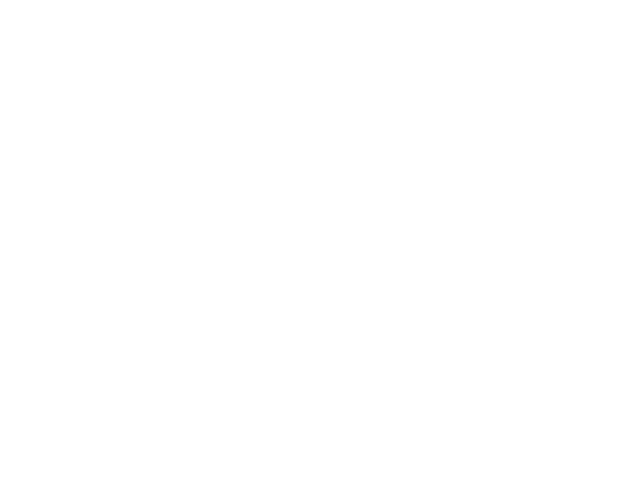

In [4]:
%matplotlib notebook
class CubeOpMode(Enum):
    ROTATION = 1
    TRANSFORM_TWIST = 2
ani = None
def exercise_2_2(mode = CubeOpMode.TRANSFORM_TWIST):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', autoscale_on=True)
    adjust_limits(ax)
    # Rotation around 3 axes separately.
    def rotate_separately_along_major_axes(ax):
        ani = animation.FuncAnimation(
            fig, partial(draw_cube, ax=ax),
            frames=update_pose(angles=np.linspace(0, 2*np.pi, 128)), blit=True, interval=2, repeat=False)
        plt.show()
    # Rotation along a twist.
    def transform_along_twist(ax, record=False):
        ani = animation.FuncAnimation(
            fig, partial(draw_cube, ax=ax),
            frames=update_pose(S=Twist3([1, 0, 0], [-1 ,0 ,1])), blit=False, interval=100, repeat=True)
        if record:
            writergif = animation.PillowWriter(fps=30) 
            ani.save('./cube_animation.gif', writer=writergif)
        else:
            plt.show()
    if mode == CubeOpMode.ROTATION:
        rotate_separately_along_major_axes(ax)
    else:
        transform_along_twist(ax)
exercise_2_2()

In [5]:
class CompactPose3D:
	def __init__(self, t = np.zeros(3), q = UnitQuaternion()):
		self.t = t
		self.q = q
	def __str__(self):
		return "Translation: " + str(self.t) + "\nQuaternion: " + str(self.q)
	def __mul__(self, other):
		translation = self.t + self.rotate(other.t)
		rotation = self.q * other.q
		return CompactPose3D(translation, rotation)
	def rotate(self, v):
		try:
			result = self.q * Quaternion.Pure(v) * self.q.conj()
			return result.v
		except ValueError:
			return np.zeros(3)
	def inverse(self):
		t_inv = self.q.conj() * Quaternion.Pure(self.t) * self.q
		return CompactPose3D(t = -t_inv.v , q = self.q.conj())
	def plot(self, **kwargs):
		self.SE3.plot(**kwargs)
	@property
	def R(self):
		return SO3(self.q.R)
	@property
	def SE3(self):
		return SE3.Rt(SO3(self.q.R), self.t)

/home/tahsin/.local/lib/python3.8/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [6]:
def exercise_2_3():
	
	base_link_T_gripper = CompactPose3D(np.array([0.5, 0.0, 0.0]), UnitQuaternion(0.188908, [-0.178688, -0.679176, -0.686371]))
	gripper_T_approach = CompactPose3D(np.array([0.0, 0.3, 0.0]), UnitQuaternion(0, [0, 0, -1]))
	base_link_T_approach = base_link_T_gripper * gripper_T_approach
	print(base_link_T_approach)
	base_link_T_approach.plot(frame='approach', color='green')
	approach_T_base_link = base_link_T_approach.inverse()
	print(approach_T_base_link)
	approach_T_base_link.plot(frame='base_link',color='red')
	I = approach_T_base_link * base_link_T_approach
	print(I)
	I.plot(frame='origin')
	plt.show()
exercise_2_3()

Translation: [ 0.65061282 -0.00182048  0.25944646]
Quaternion:  0.6864 << -0.6792,  0.1787,  0.1889 >>
Translation: [-0.43238442  0.55102137  0.00565551]
Quaternion:  0.6864 <<  0.6792, -0.1787, -0.1889 >>
Translation: [0. 0. 0.]
Quaternion:  1.0000 <<  0.0000,  0.0000,  0.0000 >>


<IPython.core.display.Javascript object>


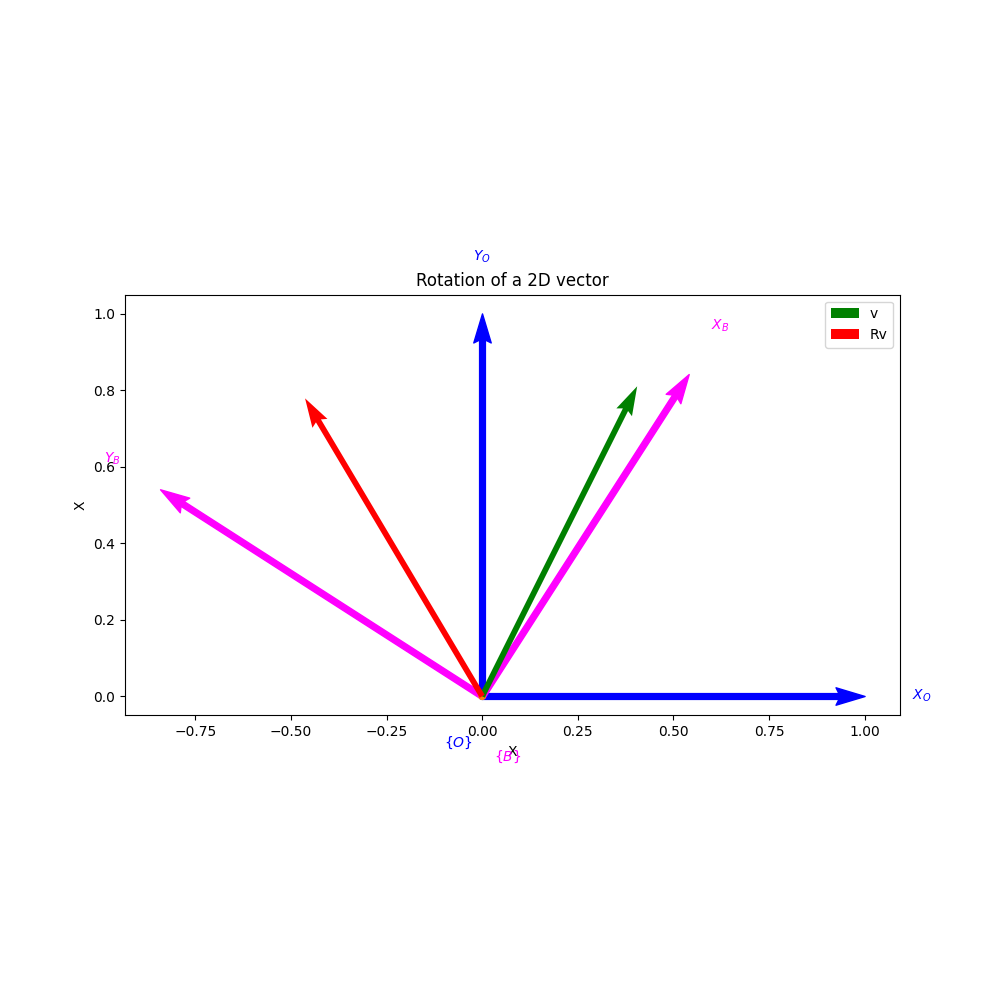

   1         0         
   0         1         

   1         0         
   0         1         

v: [1 2] vs. Rv: [[-1.14263966  1.9220756 ]]


In [19]:
def exercise_2_4():
	R = SO2(1.0)
	v = np.array([1, 2])
	origin = np.zeros(2)
	
	Rv = R*v
	SO2().plot(frame='O', color='blue')
	R.plot(frame='B', color='magenta')
	
	print(R.inv()*R)
	print(R*R.inv())
	print("v: {} vs. Rv: {}".format(v, Rv.T))
	plt.quiver(0, 0, v[0], v[1], label='v', color='green', scale=5)
	plt.quiver(0,0, Rv[0], Rv[1], label='Rv', color='red', scale=5)
	plt.legend()
	plt.title('Rotation of a 2D vector')
	plt.show()
exercise_2_4()

In [8]:
def exercise_2_5():
	def power_series(A, n):
		result = np.identity(A.shape[0]) + A
		B = A
		for i in range(2,n):
			B = np.dot(A,B)
			result = result + B/np.math.factorial(i)
		return result
	v = [-1, 0, 1]
	theta = 0.5
	A = skew(v) * theta # an element of so(3)
	power_series_library = expm(A)
	rodrigues_rotation_formula = trexp(A)
	cnt = 3
	power_series_implemented = power_series(A, cnt)
	while np.allclose(power_series_implemented, rodrigues_rotation_formula) == False:
		cnt += 1
		power_series_implemented = power_series(A, cnt)
	print(rodrigues_rotation_formula)
	print(power_series_implemented)
	print("Converged after {} iterations".format(cnt))
exercise_2_5()

[[ 0.8801223  -0.45936268 -0.1198777 ]
 [ 0.45936268  0.7602446   0.45936268]
 [-0.1198777  -0.45936268  0.8801223 ]]
[[ 0.88012153 -0.4593626  -0.11987847]
 [ 0.4593626   0.76024306  0.4593626 ]
 [-0.11987847 -0.4593626   0.88012153]]
Converged after 8 iterations


In [9]:
def exercise_2_8():
    def rodrigues_rotation_formula(omega, theta):
        th = np.linalg.norm(omega) * theta # theta = ||w|| * theta
        unit_omega = omega / np.linalg.norm(omega)
        skw = skew(unit_omega)
        return np.eye(3) + np.sin(th)*skw + (1 - np.cos(th))*np.dot(skw, skw)
    
    def compute_quat(R):
        alpha, w = R.angvec()
        return UnitQuaternion(np.cos(alpha/2.0), w*np.sin(alpha/2.0))
    
    v = [2, 3, 4]
    theta = 0.5
    A = skew(v) * theta # an element of so(3)
    R = SO3(rodrigues_rotation_formula(v, theta))
    quat = UnitQuaternion(R)
    my_quat = compute_quat(R)
    print(quat)
    print(my_quat)
    th = np.linalg.norm(v) * theta
    unit_v = v / np.linalg.norm(v)
    print(angvec2tr(th, unit_v))
exercise_2_8()

 0.2226 <<  0.3621,  0.5431,  0.7241 >>
 0.2226 <<  0.3621,  0.5431,  0.7241 >>
[[-0.63868721  0.07086278  0.76619652  0.        ]
 [ 0.71570708 -0.31094977  0.62535879  0.        ]
 [ 0.2825633   0.94778094  0.14788265  0.        ]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


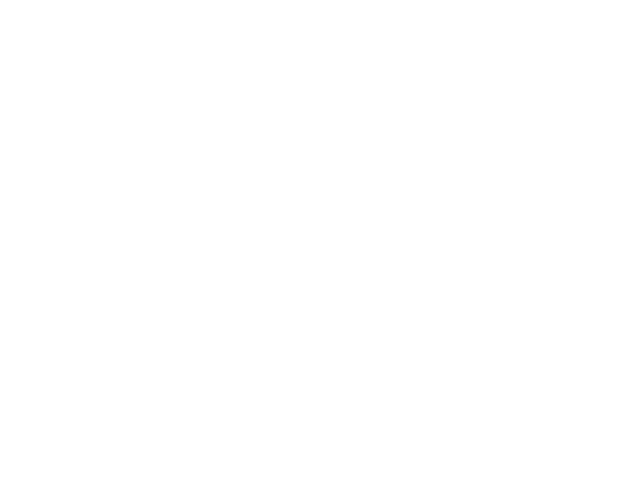

2.761492801520201 [0.18196423 0.69162863 0.69895555]
2.761492801520201 [-0.18196423 -0.69162863 -0.69895555]
camera_R_gripper:
  -0.8648    0.502    -0.01131   
  -0.0166   -0.006068  0.9998    
   0.5019    0.8648    0.01358   

gripper_R_camera:
  -0.8648   -0.0166    0.5019    
   0.502    -0.006068  0.8648    
  -0.01131   0.9998    0.01358   

   1         0         0         
   0         1         0         
   0         0         1         

Twist(camera_R_gripper): (0 0 0; 0.50249 1.9099 1.9302)
Twist(gripper_R_camera): (0 0 0; -0.50249 -1.9099 -1.9302)
True


In [10]:
def exercise_2_9():
	base_link_T_gripper = CompactPose3D(np.array([0.5, 0.0, 0.0]), UnitQuaternion(0.188908, [-0.178688, -0.679176, -0.686371]))
	base_link_T_camera = CompactPose3D(np.array([0.0, 0.3, 0.8]), UnitQuaternion(-1, [0, 0, 0]))
	base_link_T_gripper.plot(frame='gripper', color='green')
	base_link_T_camera.plot(frame='camera',color='red')
	gripper_R_camera = base_link_T_gripper.R.inv() * base_link_T_camera.R
	theta1, v1 = gripper_R_camera.angvec() 
	print(theta1, v1)
	camera_R_gripper = base_link_T_camera.R.inv() * base_link_T_gripper.R
	theta2, v2 = camera_R_gripper.angvec() 
	print(theta2, v2)
	print("camera_R_gripper:\n{}".format(camera_R_gripper))
	print("gripper_R_camera:\n{}".format(gripper_R_camera))
	print(camera_R_gripper * gripper_R_camera)
	s1 = Twist3([0,0,0], v1*theta1)
	s2 = Twist3([0,0,0], v2*theta2)
	print("Twist(camera_R_gripper): {}".format(s1))
	print("Twist(gripper_R_camera): {}".format(s2))
	s2.line().plot(color='red', marker='>', ls=':')
	print(np.allclose(s1.SE3().R, gripper_R_camera.R))
	plt.show()
exercise_2_9()

v: [2, 3, 4] vs. Rv: [-0.26865359  3.94796885  3.65258363] 


<IPython.core.display.Javascript object>


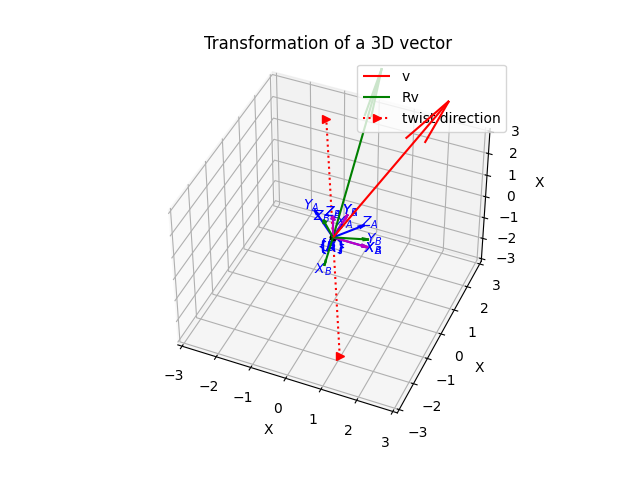

Translation: [0.0000000e+00 4.4408921e-16 0.0000000e+00]
Quaternion:  1.0000 <<  0.0000,  0.0000,  0.0000 >>
Translation: [0. 0. 0.]
Quaternion:  1.0000 <<  0.0000,  0.0000,  0.0000 >>


In [11]:
%matplotlib notebook
def exercise_2_10(record=False):
	base_link_T_gripper = CompactPose3D(np.array([2, 1, 2.5]), UnitQuaternion(0.188908, [-0.178688, -0.679176, -0.686371]))
	gripper_T_base_link = base_link_T_gripper.inverse()
	v = [2, 3, 4]
	Rv = base_link_T_gripper.rotate(v)
	print("v: {} vs. Rv: {} ".format(v, Rv, Rv))
	fig = plt.figure()
	ax = fig.add_subplot(111,projection='3d', autoscale_on=True)
	
	anim = MultiFrameAnimate(axes=ax, dims=[-3.0,3.0,-3.0, 3.0,-3.0, 3.0])
	anim.add_frame(base_link_T_gripper.SE3, color='b', frame='A', length=1.0)
	anim.add_frame(gripper_T_base_link.SE3, color='m', frame='B', length=1.0)
	def animate_frames(plot_data, animation):
		A = plot_data[0]
		B = plot_data[1]
		animation._draw(A, "A")
		animation._draw(B, "B")
	def update_frames(pose):
		pose = CompactPose3D(np.array([2, 1, 2.5]), UnitQuaternion(0.188908, [-0.178688, -0.679176, -0.686371]))
		inv_pose = base_link_T_gripper.inverse()
		s1 = pose.SE3.twist()
		s2 = inv_pose.SE3.twist()
		
		for s in np.linspace(0, 1, 100):
			A = s1.SE3(theta=s)
			B = s2.SE3(theta=s)
			yield A, B
	ani = animation.FuncAnimation(
		fig=fig,
		func=animate_frames,
		frames=update_frames(base_link_T_gripper),
		fargs=(anim, ),
		blit=False,
		interval=50,
		repeat=False,
	)
	
	plt.quiver(0, 0, 0, v[0], v[1], v[2], color='red', label='v')
	plt.quiver(0, 0, 0, Rv[0], Rv[1], Rv[2], color='green', label='Rv')
	plt.title('Transformation of a 3D vector')
	plt.legend()
	
	
	print(base_link_T_gripper * gripper_T_base_link)
	print(gripper_T_base_link * base_link_T_gripper)
	if record:
		writergif = animation.PillowWriter(fps=30) 
		ani.save('./exercise_2-10.gif', writer=writergif)
	else:
		plt.show()
exercise_2_10()

<IPython.core.display.Javascript object>


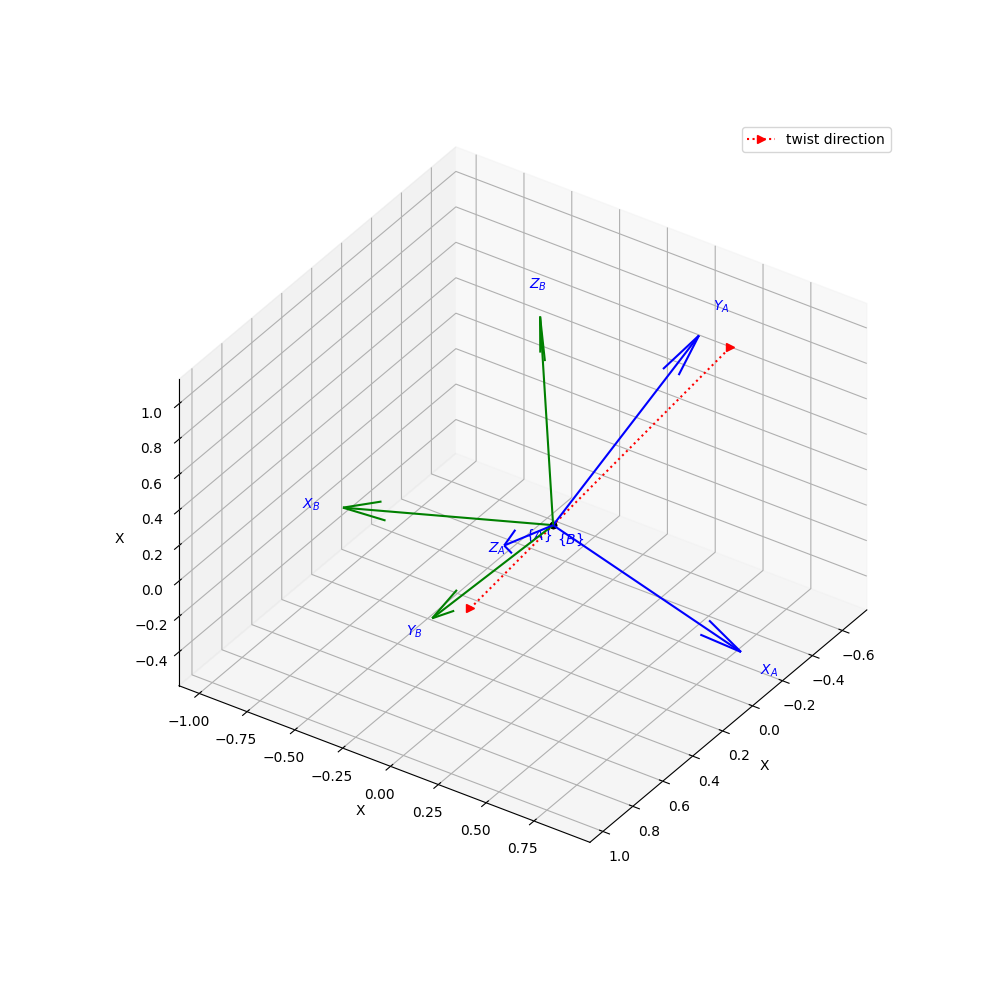

[[-0.81910311 -0.06833331 -0.56956181]
 [-0.48748217 -0.44044247  0.75390422]
 [-0.30237598  0.89517651  0.32745653]]
(0 0 0; 0.78742 -1.4892 -2.3362)
(0 0 0; -0.78742 1.4892 2.3362)


In [18]:
#matplotlib widget
def exercise_2_11():
	np.random.seed(0)
	O_R_A = SO3(UnitQuaternion.Rand().R)
	np.random.seed(1)
	O_R_B = SO3(UnitQuaternion.Rand().R)
	O_R_A.plot(frame='A')
	O_R_B.plot(frame='B', color='green')
	A_R_B = O_R_A.inv() * O_R_B
	print(A_R_B.R)
	B_R_A = A_R_B.inv()
	# Convert to ang-vec representation
	th1, w1 = A_R_B.angvec()
	th2, w2 = B_R_A.angvec()
	np.testing.assert_allclose(th1, th2)
	np.testing.assert_allclose(w1, -w2)
	# Convert to twist form
	S1 = Twist3(SE3(A_R_B))
	S2 = Twist3(SE3(B_R_A))
	S2.line().plot(color='red', marker='>', ls=':', label='twist direction')
	print(S1)
	print(S2)
	plt.legend()
	plt.show()
exercise_2_11()

⎡R₀₀  R₀₁  R₀₂⎤   ⎡cos(θₚ)⋅cos(θ_y)  sin(θₚ)⋅sin(θᵣ)⋅cos(θ_y) - sin(θ_y)⋅cos(θ
⎢             ⎥   ⎢                                                           
⎢R₁₀  R₁₁  R₁₂⎥ = ⎢sin(θ_y)⋅cos(θₚ)  sin(θₚ)⋅sin(θᵣ)⋅sin(θ_y) + cos(θᵣ)⋅cos(θ_
⎢             ⎥   ⎢                                                           
⎣R₂₀  R₂₁  R₂₂⎦   ⎣    -sin(θₚ)                    sin(θᵣ)⋅cos(θₚ)            

ᵣ)  sin(θₚ)⋅cos(θᵣ)⋅cos(θ_y) + sin(θᵣ)⋅sin(θ_y)⎤
                                               ⎥
y)  sin(θₚ)⋅sin(θ_y)⋅cos(θᵣ) - sin(θᵣ)⋅cos(θ_y)⎥
                                               ⎥
                  cos(θₚ)⋅cos(θᵣ)              ⎦
------------------
1 -> θₚ = asin(R₂₀) + π
In range:
⎡π  3⋅π⎤
⎢─, ───⎥
⎣2   2 ⎦
2 -> θₚ = -asin(R₂₀)
In range:
⎡-π   π⎤
⎢───, ─⎥
⎣ 2   2⎦
This is a suitable solution for pitch. Finishing the search for valid pitch solutions!
------------------
Rotation matrix after plugging in pitch:
                  ⎡   __________                                          

<IPython.core.display.Javascript object>


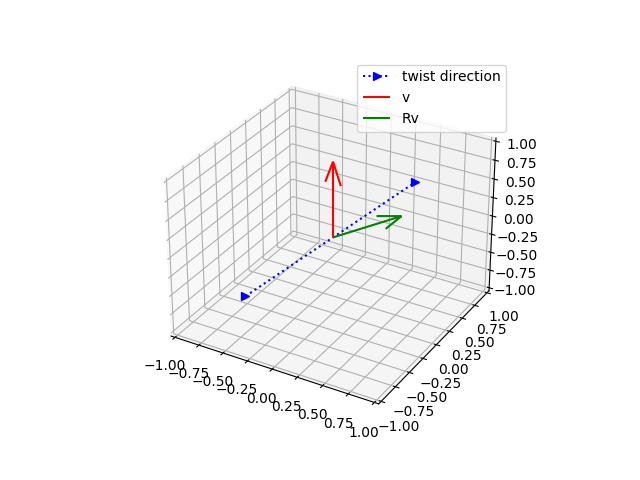

In [13]:
def exercise_2_12():
	from sympy import symbols, simplify, pretty, pprint, Matrix, MatrixSymbol, Eq, solve, asin, Interval, S, EmptySet
	from sympy.calculus.util import function_range
	from spatialmath.base.transforms3d import rpy2r
	roll, pitch, yaw = symbols('theta_r, theta_p, theta_y')
	R = Matrix(simplify(rpy2r(roll, pitch, yaw)))
	R_generic = MatrixSymbol('R', 3, 3)
	v = Matrix([0, 0, 1])
	
	eq = Eq(R_generic.as_explicit(), R)
	pprint(eq)
	pprint("------------------")
	# Solve the matrix equation for pitch, following the hint.
	pitch_solutions = solve(eq, pitch, dict=True)
	pitch_rhs_final = None
	pitch_eq_final = None
	# Loop over the possible pitch-solutions. Consider that we only want positive values as the book suggests.
	for i in range(0, len(pitch_solutions)):
		pitch_eq_candidate = pitch_solutions[i][pitch]
		k = symbols('k')
		new_pitch_eq_candidate = pitch_eq_candidate.replace(R_generic[2, 0], k, map=False)
		print("{} -> ".format(i+1), end='')
		pprint(Eq(pitch, pitch_eq_candidate))
		pprint("In range:")
		interval = function_range(new_pitch_eq_candidate, k, Interval(-1, 1))
		print(pretty(interval))
		if interval.intersect(Interval(S.NegativeInfinity, 0)) is not EmptySet:
			print("This is a suitable solution for pitch. Finishing the search for valid pitch solutions!")
			pitch_rhs_final = pitch_eq_candidate
			pitch_eq_final = Eq(pitch, pitch_rhs_final)
			break
	pprint("------------------")
	eq_v2 = eq.subs({pitch: pitch_rhs_final})
	pprint("Rotation matrix after plugging in pitch:")
	pprint(eq_v2)
	pprint("------------------")
	print("Yaw Step-1:")
	yaw_eq_step_1 = Eq(eq_v2.lhs[1,0] / eq_v2.lhs[0,0], eq_v2.rhs[1, 0] / eq_v2.rhs[0, 0])
	pprint(yaw_eq_step_1)
	print("\n")
	pprint("Yaw Step-2:")
	yaw_eq_step_2 = simplify(yaw_eq_step_1)
	pprint(yaw_eq_step_2)
	print("\n")
	pprint("Yaw Step-3:")
	yaw_eq_final = Eq(yaw, solve(yaw_eq_step_2, yaw)[0])
	pprint(yaw_eq_final)
	print("\n")
	roll_eq_step_1 = Eq(eq_v2.lhs[2,1] / eq_v2.lhs[2,2], eq_v2.rhs[2, 1] / eq_v2.rhs[2, 2])
	pprint(roll_eq_step_1)
	print("\n")
	pprint("Roll Step-1:")
	pprint(roll_eq_step_1)
	roll_eq_step_2 = simplify(roll_eq_step_1)
	print("\n")
	pprint("Roll Step-2:")
	pprint(roll_eq_step_2)
	print("\n")
	pprint("Roll Step-3:")
	roll_eq_final = Eq(roll, solve(roll_eq_step_2, roll)[0])
	pprint(roll_eq_final)
	print("---Symbolic calculations finished---")
	in_pitch = np.pi / 4.0
	in_roll = np.pi / 8.0
	in_yaw = np.pi/9.0
	R_evaled = R.subs({roll: in_roll, pitch: in_pitch, yaw: in_yaw})
	roll_recv = float(roll_eq_final.subs({R_generic[2,1]: R_evaled[2,1], R_generic[2,2]: R_evaled[2,2]}).rhs.evalf())
	pitch_recv = float(pitch_eq_final.subs({R_generic[2,0]: R_evaled[2,0]}).rhs.evalf())
	yaw_recv = float(yaw_eq_final.subs({R_generic[1,0]: R_evaled[1,0], R_generic[0,0]: R_evaled[0,0]}).rhs.evalf())
	np.testing.assert_allclose(in_roll, roll_recv)
	np.testing.assert_allclose(in_pitch, pitch_recv)
	np.testing.assert_allclose(in_yaw, yaw_recv)
	print("---Round-trip tests have succesfully finished---")
	S = Twist3(SE3(SO3(np.array(R_evaled).astype(np.float64))))
	
	Rv = (R @ v).T
	Rv_ = np.array(Rv.subs({roll: in_roll, pitch: in_pitch, yaw: in_yaw})).astype(np.float64).T
	fig = plt.figure()
	ax = fig.add_subplot(111,projection='3d', autoscale_on=True)
	adjust_limits(ax, 1)
	S.line().plot(color='blue', marker='>', ls=':', label='twist direction')
	plt.quiver(0, 0, 0, v[0], v[1], v[2], color='red', label='v')
	plt.quiver(0, 0, 0, Rv_[0], Rv_[1], Rv_[2], color='green', label='Rv')
	plt.legend()
	plt.show()
exercise_2_12()

## Exercise 2.15
$T_1T_2 = \begin{pmatrix} R_1R_2 & t_1 + R_1t_2\\ 0_{1x3} & 1\end{pmatrix} \rightarrow \text{Eq. 2.24}$ 

$T^{-1} = \begin{pmatrix} R_T & -R^Tt\\ 0_{1x3} & 1\end{pmatrix} \rightarrow \text{Eq. 2.25}$

Given these two $TT^{-1}$ becomes:

$TT^{-1} = \begin{pmatrix}  RR^T & t -RR^Tt\\ 0_{1x3} &1\end{pmatrix}$,

simplifying:

$TT^{-1} = \begin{pmatrix}  I & t - t\\ 0_{1x3} &1\end{pmatrix} = \begin{pmatrix}  I & 0\\ 0_{1x3} &1\end{pmatrix}$

## Exercise 2.16
The question is $T^{-1} \stackrel{?}{=} T^T$
We know that for any matrix $A$, the multiplication with its inverse leads to identity matrix. In this setting, we will prove that this equality does not hold for all homogeneous transformation matrices through contradiction. 

Let $T$ be homogeneous transformation matrix:

$T = \begin{pmatrix}R && t\\ 0 && 1 \end{pmatrix}$, then $T^T = \begin{pmatrix}R^T && 0\\ t && 1 \end{pmatrix}$

And let's assume its transpose is equal to its inverse. Then, the following equality **must** hold for all homogeneous transformation matrices:
$TT^T = \begin{pmatrix}RR^T + t \otimes t && t\\ t^T && 1\end{pmatrix} = I_{4x4}$

At this point it suffices to show at least 1 $t$ that breaks this equality. In fact all $t$'s except $t=\begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix}$ invalidates this equality. 


The transpose of a homogeneous transformation matrix is only equal to its inverse, when this matrix represents a pure rotation. For all other cases, this does not hold, so $T^{-1} \neq T^T | T.t \neq 0_{3x1} \blacksquare$

## Exercise 2.17

In order to solve this problem, we need to introduce the __rotational operator__ concept. So a point vector $^0p_A$ can be rotated with a rotation matrix $R$ and the resultant point vector would be $^0p_B$. In compact form:

$^0p_B = R \cdot ^0p_A$

The same rotational operator could be used to left-multiply an existing rotation matrix in order to end up with a new rotation matrix:

$^0R_B = R \cdot ^0R_A$

These two identities will be used when deriving the expression for *rotation around a point*. Let there be a frame $A$ expressed with respect to $O$ and a point $C$ which we want to rotate $A$ around it. Finally, let the frame after the rotational operation to be $A_f$. With all these identities, we have:

$0^T_{A_f} = \begin{pmatrix}I & ^0t_C\\0 & 1\end{pmatrix} \cdot \begin{pmatrix}R & 0\\0 & 1\end{pmatrix} \cdot \underbrace{\begin{pmatrix}I & -^0t_C\\0 & 1\end{pmatrix} \cdot \begin{pmatrix} ^0R_A & ^0t_A\\0 & 1\end{pmatrix}}$

$0^T_{A_f} = \begin{pmatrix}I & ^0t_C\\0 & 1\end{pmatrix} \cdot \underbrace{\begin{pmatrix}R & 0\\0 & 1\end{pmatrix} \cdot \begin{pmatrix}^0R_A & \underbrace{^0t_A-^0t_C}_{^Ct_A}\\0 & 1\end{pmatrix}}$

$0^T_{A_f} = \begin{pmatrix}I & ^0t_C\\0 & 1\end{pmatrix} \cdot \begin{pmatrix}R^0R_A & R^Ct_A\\0 & 1\end{pmatrix}$

Here, we will exploit the problem structure in order to represent the point vector $^Ct_A$ in $\{O\}$ frame. Since $C$ is actually a point, we can specify the rotation of its frame $\{C\}$ however we want. Let its rotation be identity. Since now both $\{C\}$ and $\{O\}$ have the same orientation, we can transport the point vector into frame $\{O\}$. Let's call it $^0t_{A'}$. The following plot visually verifies $^Ct_A = ^0t_{A'}$:

<IPython.core.display.Javascript object>


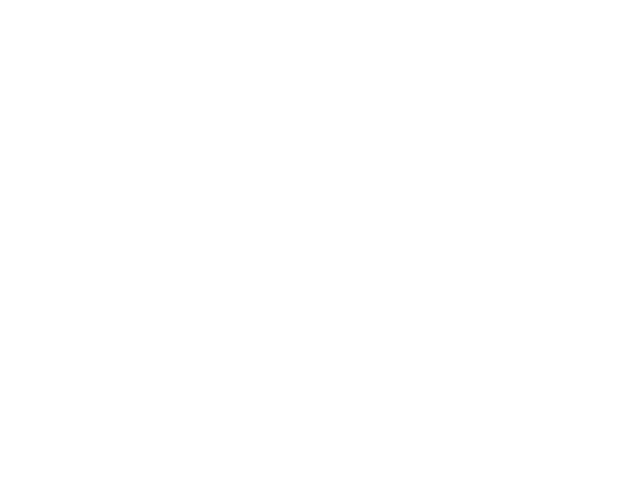

<IPython.core.display.Javascript object>


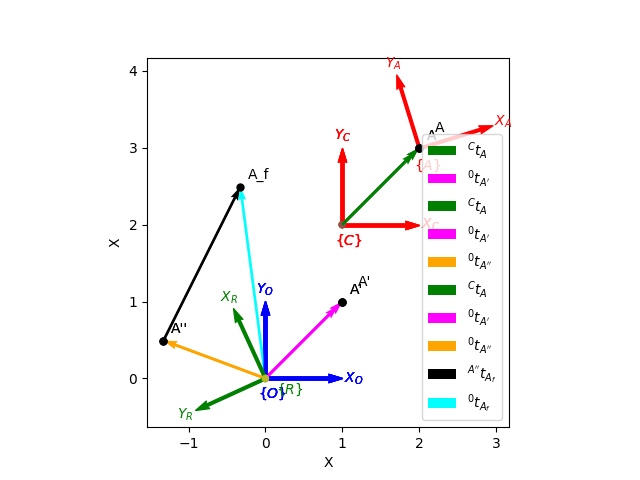

In [14]:
fig = plt.figure()
SE2().plot(frame='O')
C = SE2(transl2(1, 2))
C.plot(frame='C', color='red')
A = [2, 3]
A_ = A - C.t
plt.plot(A[0], A[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A[0] + 0.2, A[1] + 0.2,'A')
plt.quiver(C.t[0], C.t[1], A_[0], A_[1], label=r'$^Ct_A$', color='green', scale=5)
plt.plot(A_[0], A_[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A_[0] + 0.2, A_[1] + 0.2,"A'")
plt.quiver(0, 0, A_[0], A_[1], label=r"$^0t_{A'}$", color='magenta', scale=5)
plt.xlim([-2, 4])
plt.ylim([-1, 4])
plt.legend()
plt.show()

After change of notation, the equation becomes:

$0^T_{A_f} = \begin{pmatrix}I & ^0t_C\\0 & 1\end{pmatrix} \cdot \begin{pmatrix}R^0R_A & \underbrace{R^0t_{A'}}\\0 & 1\end{pmatrix}$

Rotational operator $R$ transforms its input vector such that a new terminal point comes out $\rightarrow R^0t_{A'} = ^0t_{A''}$

In [15]:
from spatialmath.base.transforms2d import trot2
plt.rcParams['figure.figsize'] = [10, 10]
SE2().plot(frame='O')
C = SE2(transl2(1, 2))
C.plot(frame='C', color='red')
A = [2, 3]
A_ = A - C.t
plt.plot(A[0], A[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A[0] + 0.1, A[1] + 0.1,'A')
plt.quiver(C.t[0], C.t[1], A_[0], A_[1], label=r'$^Ct_A$', color='green', scale_units='xy', angles='xy', scale=1)
plt.plot(A_[0], A_[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A_[0] + 0.1, A_[1] + 0.1,"A'")
plt.quiver(0, 0, A_[0], A_[1], label=r"$^0t_{A'}$", color='magenta', scale_units='xy', angles='xy', scale=1)

R = SE2(trot2(2))
A_ = SE2(transl2(A_[0], A_[1]))
RA_ = (R * A_).t
plt.plot(RA_[0], RA_[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(RA_[0] + 0.1, RA_[1] + 0.1,"A''")
plt.quiver(0, 0, RA_[0], RA_[1], label=r"$^0t_{A''}$", color='orange', scale_units='xy', angles='xy', scale=1)
plt.xlim([-3, 4])
plt.ylim([-3, 4])
plt.legend()
plt.show()

After the rotation of vector:

$0^T_{A_f} = \begin{pmatrix}I & ^0t_C\\0 & 1\end{pmatrix} \cdot \begin{pmatrix}R^0R_A & \underbrace{^0t_{A''}}\\0 & 1\end{pmatrix} = \begin{pmatrix} R^0R_A & ^0t_{A''} + ^0t_C \\0 & 1 \end{pmatrix}$

We can add two vectors if they are expressed in same frame. So $^0t_{A_f} = ^0t_{A''} + ^0t_C$. The following plot illustrates this geometrically. 

In [16]:
SE2().plot(frame='O')
C = SE2(transl2(1, 2))
C.plot(frame='C', color='red')
A = [2, 3]
A_ = A - C.t
plt.plot(A[0], A[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A[0] + 0.1, A[1] + 0.1,'A')
plt.quiver(C.t[0], C.t[1], A_[0], A_[1], label=r'$^Ct_A$', color='green', scale_units='xy', angles='xy', scale=1)
plt.plot(A_[0], A_[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(A_[0] + 0.1, A_[1] + 0.1,"A'")
plt.quiver(0, 0, A_[0], A_[1], label=r"$^0t_{A'}$", color='magenta', scale_units='xy', angles='xy', scale=1)

R = SE2(trot2(2))
A_ = SE2(transl2(A_[0], A_[1]))
RA_ = (R * A_).t
plt.plot(RA_[0], RA_[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.text(RA_[0] + 0.1, RA_[1] + 0.1,"A''")
plt.quiver(0, 0, RA_[0], RA_[1], label=r"$^0t_{A''}$", color='orange', scale_units='xy', angles='xy', scale=1)
A_f = RA_ + C.t
plt.plot(A_f[0], A_f[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.quiver(RA_[0], RA_[1], A_f[0] - RA_[0], A_f[1] - RA_[1], label=r"$^{A''}t_{A_f}$", color='black', scale_units='xy', angles='xy', scale=1)
plt.quiver(0, 0, A_f[0], A_f[1], label=r"$^0t_{A_f}$", color='cyan', scale_units='xy', angles='xy', scale=1)
plt.text(A_f[0] + 0.1, A_f[1] + 0.1,"A_f")
plt.xlim([-3, 4])
plt.ylim([-3, 4])
plt.legend()
plt.show()

$0^T_{A_f} =  \begin{pmatrix} R^0R_A & ^0t_{A_f} \\0 & 1 \end{pmatrix} = \begin{pmatrix} ^0R_{A_f} & ^0t_{A_f} \\0 & 1 \end{pmatrix}$

The term $R^0R_A$ corresponds to $^0R_{A_f}$ by definition. This is natural as it rotates the frame $\{A\}$ with the angle represented by $R$ wrt $\{O\}$.

In [17]:
from spatialmath.geom2d import Line2
SE2().plot(frame='O')
O_T_A = SE2(2,3,0.3)
O_T_A.plot(frame='A', color='red')
R = SE2(trot2(2))
R.plot(frame='R', color='green')
O_T_Af = SE2(A_f[0], A_f[1], (A*R).theta())
O_T_Af.plot(frame="A_f")
plt.plot(C.t[0], C.t[1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
plt.xlim([-3, 4])
plt.ylim([-3, 4])
A_T_Af = O_T_A.inv() * O_T_Af
s = A_T_Af.Twist2()
p1 = [C.t[0] + s.v[0], C.t[1] + s.v[1]]
p2 = [C.t[0] - s.v[0], C.t[1] - s.v[1]]
Line2.TwoPoints(p1, p2).plot(linestyle='--', label="screw axis")
plt.legend()
plt.show()

TypeError: can't multiply sequence by non-int of type 'SE2'

## Exercise 2.18

In [ ]:
from spatialmath.base.transforms3d import rpy2r
i = 0
for roll in np.linspace(-np.pi/2.0, np.pi/2.0, 20):
    for pitch in np.linspace(-np.pi/2.0, np.pi/2.0, 20):
        for yaw in np.linspace(-np.pi/2.0, np.pi/2.0, 20):
            i += 1
            r_recv, p_recv, y_recv = tr2rpy(rpy2r(roll, pitch, yaw))
            if abs(roll - r_recv) > 1e-2 or abs(yaw - y_recv) > 1e-2 :
                print("{} -> roll[in]: {} vs. roll[out]: {}, diff: {}".format(i, roll, r_recv, roll - r_recv))
                print("{} -> yaw[in]: {} vs. yaw[out]: {}, diff: {}".format(i, yaw, y_recv, yaw - y_recv))                      

## Exercise 2.19

Take $(M+N)(M+N)$ as an example. The distributive property of matrices generates $M^2 + MN + NM + N^2$. It is clear that $MN=NM$ (commutative property) needs to hold for this expression to resolve as $M^2 + 2MN + N^2$. Let's do the Taylor expansion for $e^Me^N$ case:

$(I + M + \dfrac{M^2}{2} + ...)(I + N + \dfrac{N^2}{2} + ...)$

We will make a selective multiplication once we reach the 3rd terms in order to show the condition defined above:

$I + MI + IN + \dfrac{M^2}{2} + MN + \dfrac{N^2}{2} + .... \rightarrow \text{Eq.1}$                  

Let's do the Taylor expansion for $e^{(M+N)}$:

$I + M+N + \dfrac{(M+N)^2}{2} + ... = I + M+N + \dfrac{M^2}{2} + \dfrac{MN}{2} + \dfrac{NM}{2} + \dfrac{N^2}{2} + ... \rightarrow \text{Eq.2}$

For Eq.1 and Eq. 2 to be equal, the following equality needs to hold $\dfrac{MN}{2} = \dfrac{NM}{2} \rightarrow MN=NM$, which is only possible when $M$ and $N$ are commutative. Therefore in general $e^xe^y \neq e^{x+y} \blacksquare$


## Exercise 2.20

In [ ]:
%matplotlib widget
import numpy as np
def exercise_2_20():
    from spatialmath import SO2, SO3,  UnitQuaternion
    from spatialmath.base.transforms3d import tr2rpy
    cam_z = np.array([0, 1, 0])
    cam_y = np.array([0, 0, -1])
    cam_x = np.cross(cam_z, cam_y)
    world_R_camera = SO3(np.array([cam_x, cam_y, cam_z]).T)
    world_R_camera.plot(frame='camera')
    print("Attitude from rotation matrix: {}".format(tr2rpy(world_R_camera.R)[0]))
    print("Attitude from unit quaternion: {}".format(UnitQuaternion(world_R_camera).eul()[0]))
exercise_2_20()